# IMDB Review Sentiment Classsification

##### Dataset: IMDB movie reviews labeled as positive and negative. We will try to build an NLP model to predict review sentiments using GloVe word embeddings.

In [1]:
#Import the necessary libraries
import numpy as np
import pandas as pd
import spacy
from sklearn.preprocessing import LabelBinarizer
from bs4 import BeautifulSoup
import nltk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#nltk.download('stopwords')
#nltk.download('punkt')
nlp = spacy.load('en_core_web_md')

In [2]:
#load the data
df = pd.read_csv("IMDB Demo.csv")

In [3]:
#Take a quick look
df.describe()

,review,sentiment
count,14999,14999
unique,14960,2
top,"Don't get me wrong, I assumed this movie would...",negative
freq,2,7609


In [4]:
#Take a look at a single review and its sentiment label
example_review = df['review'][3]

example_sentiment = df['sentiment'][3]

print("Comment #3: " + example_review)

print("\nSentiment label for the comment: " + example_sentiment)

Comment #3: Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.

Sentiment label for the comment: negative


In [5]:
#Split the variables and the labels
X = df['review']
y = df['sentiment']

In [6]:
#Labels are in string format, we need to convert them into numeric format in order to use them.
binarizer = LabelBinarizer()
y = binarizer.fit_transform(y)
y

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [7]:
example_review

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [8]:
# We need to preprocess the review before we can use them. We will use the bs4 library to get rid of the html tags.
# Let's create a function for the task
def remove_html_tags(review):
    soup = BeautifulSoup(review)
    detagged_review = soup.get_text()
    return detagged_review

In [9]:
#The function is working, <br /> tags are gone.
remove_html_tags(example_review)

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [10]:
# We will create a function that removes stop words and punctuations in each review
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Get the stop words in English and store them
stop_words = list(stopwords.words('english'))

#Get the list of punctuation symbols from the string library
punctuations = list(string.punctuation)
punctuations.remove("'")
punctuations.remove('"')

#Make a final list of the things to remove from each comment
to_remove = stop_words + punctuations

In [11]:
#This functions removes the stop words and punctuation from a review.
def remove_stopwords_punkt(review):
    # Tokenize the sentence first
    word_tokens = word_tokenize(review)
    # Get rid of the punctuations and stop words and keep the remaining words.
    word_tokens = [w for w in word_tokens if not w in to_remove]
    filtered_sentence = " ".join(word_tokens)

    return filtered_sentence

In [12]:
#Both functions seem to be working with minor errors.
detagged_ex_review = remove_html_tags(example_review)
remove_stopwords_punkt(detagged_ex_review)

"Basically 's family little boy Jake thinks 's zombie closet parents fighting time.This movie slower soap opera ... suddenly Jake decides become Rambo kill zombie.OK first 're going make film must Decide thriller drama As drama movie watchable Parents divorcing arguing like real life And Jake closet totally ruins film I expected see BOOGEYMAN similar movie instead watched drama meaningless thriller spots.3 10 well playing parents descent dialogs As shots Jake ignore"

In [13]:
DF = list(map(lambda x:remove_stopwords_punkt(remove_html_tags(x)), X))

In [14]:
DF = list(map(lambda x:nlp(x).vector, DF))

In [15]:
DF = np.array(DF)
DF_label = np.array(y).reshape(-1,)

In [16]:
#Split the preprocessed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
DF, DF_label, test_size=0.10, random_state=42)

In [17]:
import tensorflow.keras as k
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
def create_model():
    Input = k.Input(shape = (300,))
    X = Dense(50, activation = 'relu')(Input)
    output = Dense(1, activation= 'sigmoid')(X)
    
    model = k.Model(inputs = Input, outputs = output)
    return model
    

In [41]:
model = create_model()
model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

Epoch 00025: early stopping
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


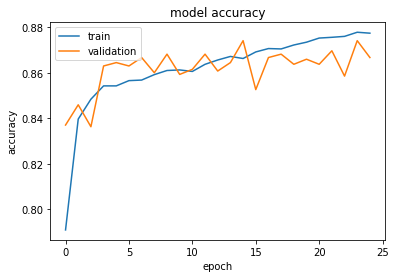

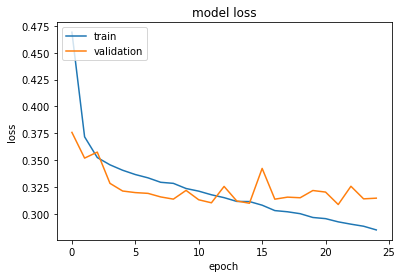

In [42]:
#Add early stopping with a patience of 10 epochs
es = EarlyStopping(monitor='val_accuracy', mode = "max", verbose=1, patience = 10)
history = model.fit(X_train, y_train, validation_split=0.10, epochs= 200, batch_size= 20, verbose=0, callbacks=[es])
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [43]:
#Calculate test accuracy
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", str(round(accuracy*100, 2)) + "%")

Test Accuracy: 84.8%


In [44]:
#Get class predictions for the test set
preds = model.predict(X_test, verbose=0)
preds = [0 if i < 0.5 else 1 for i in preds]

In [45]:
#Take a look at the confusion matrix, 1:positive review, 0:negative review
y_true = pd.Series(y_test)
y_pred = pd.Series(preds)
pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,651,131,782
1,97,621,718
All,748,752,1500


In [46]:
# Look at precision, recall and f1 scores. The predictions seem to be balanced across labels.
from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(y_test, preds)

precision = precision_score(y_test, preds)

recall = recall_score(y_test, preds)

print("Precision:", str(round(precision*100, 2)) + "%")
print("Recall:", str(round(recall*100, 2)) + "%")
print("F1:", str(round(f1*100, 2)) + "%")

Precision: 82.58%
Recall: 86.49%
F1: 84.49%


In [47]:
# Let's try the model on some of our reviews.
my_positive_review = '''I think this movie deserves an oscar. It was one of the most exciting movies I have ever watched.
Solid acting and very convincing special effects.'''
my_negative_review = '''This movie is a total waste of time. Terrible acting and a very weak storyline. I do not 
recommend it for anyone.'''

In [48]:
# We need to preprocess them before using
pos_rev = remove_stopwords_punkt(remove_html_tags(my_positive_review))
neg_rev = remove_stopwords_punkt(remove_html_tags(my_negative_review))
pos_rev = nlp(pos_rev).vector
neg_rev = nlp(neg_rev).vector

In [49]:
#The model seems to be classifying our reviews correctly
processed_reviews = np.array([pos_rev, neg_rev])
preds = model.predict(processed_reviews)
preds = [0 if i < 0.5 else 1 for i in preds]
preds

[1, 0]